<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [2]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16331842238658196218
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13896777728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18283725137384424744
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Loading

Load images and respective labels

In [4]:
base_dir = r"C:\Users\Blix\Downloads\Data"

In [5]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [6]:
image_height = 128
image_width = 128
batch_size = 32

In [7]:
images = []
labels = []
for style in styles:
    style_dir = os.path.join(base_dir, style)
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        try:
            img = Image.open(image_path).convert('RGB') # Load image and convert to RGB
            img = img.resize((image_height, image_width)) # Resize images to a consistent size
            img_array = np.array(img)
            images.append(img_array)
            labels.append(style) # Use the style name as the label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

In [8]:
# Convert lists to numpy arrays
images = np.array(images)

## Data Split

In [9]:
# Train-Validation-Test Split is 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Convert y_train to a NumPy array to use NumPy functions
y_train_np = np.array(y_train)

# Get unique values and their counts
unique_elements, counts = np.unique(y_train_np, return_counts=True)

# Print the counts
print("Counts of each style in y_train:")
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

Counts of each style in y_train:
Art_Nouveau_Modern: 3018
Baroque: 2992
Color_Field_Painting: 1115
Cubism: 1809
Expressionism: 6782
Fauvism: 683
Impressionism: 13914
Minimalism: 930
Naive_Art_Primitivism: 1696
Pop_Art: 1036
Realism: 8077
Renaissance: 4593
Rococo: 1464
Romanticism: 4915
Symbolism: 3152
Ukiyo_e: 811


In [11]:
# Convert y_val to a NumPy array to use NumPy functions
y_val_np = np.array(y_val)

# Get unique values and their counts
unique_elements, counts = np.unique(y_val_np, return_counts=True)

# Print the counts
print("Counts of each style in y_val:")
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

Counts of each style in y_val:
Art_Nouveau_Modern: 673
Baroque: 620
Color_Field_Painting: 243
Cubism: 376
Expressionism: 1435
Fauvism: 122
Impressionism: 3038
Minimalism: 201
Naive_Art_Primitivism: 344
Pop_Art: 226
Realism: 1761
Renaissance: 948
Rococo: 311
Romanticism: 1074
Symbolism: 676
Ukiyo_e: 163


In [12]:
label_to_index = {style: i for i, style in enumerate(styles)}
y_train_encoded = to_categorical([label_to_index[label] for label in y_train], num_classes=len(styles))
y_val_encoded = to_categorical([label_to_index[label] for label in y_val], num_classes=len(styles))
y_test_encoded = to_categorical([label_to_index[label] for label in y_test], num_classes=len(styles))

# Normalize the image data after splitting
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [21]:
from tensorflow.keras.utils import to_categorical, Sequence

In [22]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Ensure that batch_x maintains its original shape or is adjusted as needed for your model
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [23]:
train_gen = DataGenerator(X_train, y_train_encoded, batch_size)
val_gen = DataGenerator(X_val, y_val_encoded, batch_size) # Added validation generator
test_gen = DataGenerator(X_test, y_test_encoded, batch_size)

## Model Training

In [24]:
model = tf.keras.Sequential([
    # First block with batch normalization
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),
    
    # Second block
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    
    # Third block
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    
    # Fourth block
    tf.keras.layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    
    # Dense layers
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(styles), activation='softmax')
])

In [25]:
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 128, 128, 64)     

In [26]:
# Initialize starting learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing = 0.1),
    metrics=['accuracy']
)

In [27]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,
)

In [28]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=0.0001,
    verbose=1
)

In [ ]:
# Fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,  # Use the validation generator
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    batch_size= batch_size
)

Epoch 1/1000
1781/1781 [==============================] - 116s 64ms/step - loss: 2.6310 - accuracy: 0.2622 - val_loss: 2.4418 - val_accuracy: 0.3069 - lr: 0.0010
Epoch 2/1000
1781/1781 [==============================] - 114s 64ms/step - loss: 2.3235 - accuracy: 0.3230 - val_loss: 2.6293 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 3/1000
1781/1781 [==============================] - 113s 64ms/step - loss: 2.2234 - accuracy: 0.3534 - val_loss: 2.2840 - val_accuracy: 0.3385 - lr: 0.0010
Epoch 4/1000
1781/1781 [==============================] - 115s 64ms/step - loss: 2.1830 - accuracy: 0.3712 - val_loss: 2.4736 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 5/1000
1781/1781 [==============================] - 114s 64ms/step - loss: 2.1448 - accuracy: 0.3850 - val_loss: 2.1909 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 6/1000
1781/1781 [==============================] - 113s 64ms/step - loss: 2.1138 - accuracy: 0.3955 - val_loss: 2.5220 - val_accuracy: 0.2191 - lr: 0.0010
Epoch 7/1000
1781/1781 [====

## Model Evaluation

In [33]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

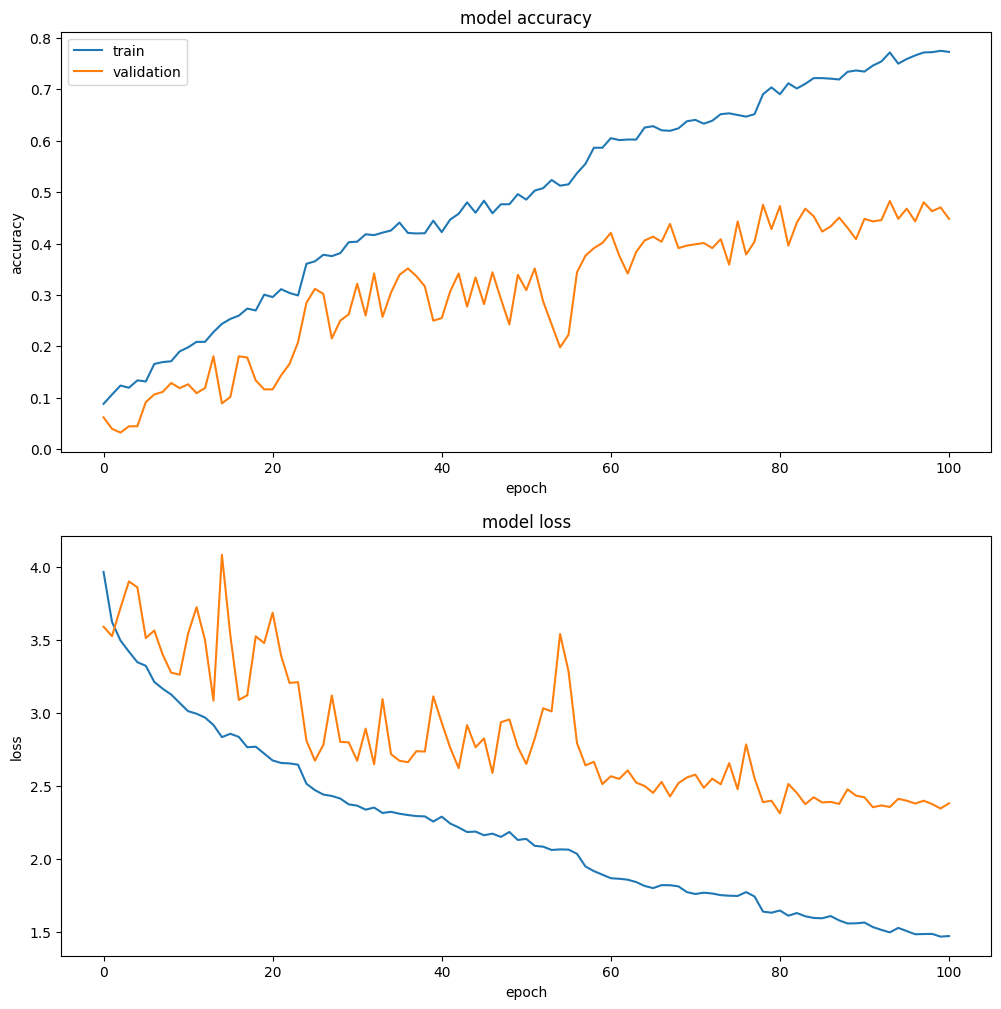

In [34]:
# Plot Loss Graphs
plot_history(history)

In [35]:
model.evaluate(X_test, y_test_encoded)

13/13 [==============================] - 1s 60ms/step - loss: 2.4116 - accuracy: 0.4604


[2.411635398864746, 0.46039605140686035]

In [36]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = [styles[i] for i in y_pred_classes]
y_test_classes = [styles[i] for i in y_test_classes]
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

13/13 [==============================] - 1s 60ms/step
Classification Report:
                            precision    recall  f1-score   support

    Abstract Expressionism       0.43      0.30      0.35        10
           Action Painting       0.61      0.69      0.65        16
         Analytical Cubism       0.93      0.82      0.88        17
        Art Nouveau Modern       0.31      0.36      0.33        14
                   Baroque       0.80      0.64      0.71        25
      Color Field Painting       0.56      0.69      0.62        13
      Contemporary Realism       0.42      0.42      0.42        12
                    Cubism       0.36      0.29      0.32        14
         Early Renaissance       0.43      0.60      0.50        15
             Expressionism       0.22      0.15      0.18        13
                   Fauvism       0.42      0.44      0.43        18
          High Renaissance       0.33      0.42      0.37        12
             Impressionism       0.20 